<a href="https://colab.research.google.com/github/ttogle918/NLU_3-/blob/main/practice/%EC%B5%9C%EC%A7%80%ED%98%84_sts_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLU - 문장 유사도 계산 (STS)**



- RoBERTa 적용
  - klue/roberta-base

참고 : 
- [code](https://www.datafied.world/detailed-notebook-to-fine-tune-roberta-for-beginners-222)
- [huggingface RobertaModel](https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel)
- [huggingface git](https://github.com/huggingface/transformers/blob/v4.19.2/src/transformers/models/roberta/modeling_roberta.py#L692)
- [huggingface models](https://huggingface.co/models)

In [ ]:
!pip install optuna
!pip install pytorch-transformers
!pip install transformers
!pip install datasets

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score
from scipy import stats
import time
import matplotlib.pyplot as plt

In [2]:
# gpu 연산이 가능하면 'cuda:0', 아니면 'cpu' 출력
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device, torch.cuda.device_count()

(device(type='cuda', index=0), 1)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from transformers import AutoTokenizer, AutoModel, RobertaConfig
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

# Load dataset

### KLUE 데이터셋 및 전처리 과정 예시

[klue-sts-벤치마크-구조-보기](https://velog.io/@soyoun9798/KLUE-STS-%EB%B2%A4%EC%B9%98%EB%A7%88%ED%81%AC-%EA%B5%AC%EC%A1%B0-%EB%B3%B4%EA%B8%B0)


In [5]:
from datasets import load_dataset
dataset = load_dataset('klue', 'sts')

Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
print(f"type(dataset) : {type(dataset)}")
print(f"key : {dataset.keys()}")
print(f"type dataset[train] : {type(dataset['train'])}")
print(f"dataset[train] : {dataset['train']} \n\n")
# labels : { 이진분류 : 1, 반올림 값 : 3.7, 실제 label 값 : 3.71422... }
dataset['train'][0]

type(dataset) : <class 'datasets.dataset_dict.DatasetDict'>
key : dict_keys(['train', 'validation'])
type dataset[train] : <class 'datasets.arrow_dataset.Dataset'>
dataset[train] : Dataset({
    features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
    num_rows: 11668
}) 




{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [ ]:
# 데이터 4개만 확인
i = 0
for d in dataset['train'] :
  if i == 4 : break
  print(d['sentence1'],'/',  d['sentence2'])
  i += 1

숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다. / 숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.
위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다. / 시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.
회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘. / 사람들이 주로 네이버 메일을 쓰는 이유를 알려줘
긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업성공패키지, 청년구직활동지원금, 긴급복지지원제도 지원금과는 중복 수급이 불가능하다. / 고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.


In [9]:
import re
i = 0
for d in dataset['train'] :
  if i == 4 : break
  print(re.sub('[^가-힣A-Za-z0-9]','', d['sentence1']),'/',  re.sub('[^가-힣A-Za-z0-9]','', d['sentence2']))
  i += 1

숙소위치는찾기쉽고일반적인한국의반지하숙소입니다 / 숙박시설의위치는쉽게찾을수있고한국의대표적인반지하숙박시설입니다
위반행위조사등을거부방해기피한자는500만원이하과태료부과대상이다 / 시민들스스로자발적인예방노력을한것은아산뿐만이아니었다
회사가보낸메일은이지메일이아니라다른지메일계정으로전달해줘 / 사람들이주로네이버메일을쓰는이유를알려줘
긴급고용안정지원금은지역고용대응등특별지원금지자체별소상공인지원사업취업성공패키지청년구직활동지원금긴급복지지원제도지원금과는중복수급이불가능하다 / 고용보험이1차고용안전망이라면국민취업지원제도는2차고용안전망입니다


In [12]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')

result = tokenizer(re.sub('[^가-힣]','', dataset['train']['sentence1'][0]), re.sub('[^가-힣]','', dataset['train']['sentence2'][0]))
print('input_ids', result.input_ids)
print('token_type_ids', result.token_type_ids)
print('attention_mask', result.attention_mask)
print(tokenizer.decode(result['input_ids']))

input_ids [0, 9206, 12765, 2259, 2688, 2015, 2961, 2088, 2210, 2536, 31221, 2470, 2226, 2079, 2536, 2118, 2205, 2300, 2024, 12190, 2, 8134, 10171, 2079, 12765, 2259, 2961, 2318, 2688, 2069, 2113, 2689, 2088, 2470, 2226, 2079, 5718, 31221, 2536, 2118, 2205, 2300, 2042, 10171, 12190, 2]
token_type_ids [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[CLS] 숙소위치는찾기쉽고일반적인한국의반지하숙소입니다 [SEP] 숙박시설의위치는쉽게찾을수있고한국의대표적인반지하숙박시설입니다 [SEP]


In [20]:
model = AutoModel.from_pretrained('klue/roberta-base')#, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')
result = tokenizer(dataset['train']['sentence1'][0], dataset['train']['sentence2'][0], return_tensors='pt')
outputs = model(**result)
# 'textattack/roberta-base-STS-B'

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [16]:
outputs['pooler_output'].shape, outputs['last_hidden_state'].shape, 

(torch.Size([1, 768]), torch.Size([1, 41, 768]))

In [22]:
del outputs
del model
del tokenizer
del result

# Dataset Tokenizing -> dataLoader

In [6]:
import re
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [22]:
class CustomDataset(Dataset):
    def __init__(self, dataset, appended_data=None, appended_data2=None):
        self.sentence1, self.sentence2, self.labels = self.make_dataset(dataset, appended_data, appended_data2)

    def make_dataset(self, dataset, appended_data=None, appended_data2=None):
        """
        self.label : dataset의 label의 list
        self.input : sentence1, sentence2를 tokenizer한 값을 이어 붙임 
        rlabels : # real-label -> 0 ~ 5일 때, binary-label : 0 or 1
        """
        sentence1, sentence2, rlabels = [], [], []

        for data in dataset :
          # rlabels.append(data['labels']['real-label'])
          rlabels.append(data['labels']['binary-label'])
          sentence1.append(self.cleaning(data['sentence1']))
          sentence2.append(self.cleaning(data['sentence2']))

        if appended_data is not None :
          for data in appended_data :
            if data['score'] is None or data['sentence1'] is None or data['sentence2'] is None :
              continue 
            rlabels.append(data['score'])
            sentence1.append(self.cleaning(data['sentence1']))
            sentence2.append(self.cleaning(data['sentence2']))

        if appended_data2 is not None :
          for data in appended_data2 :
            if data['score'] is None or data['sentence1'] is None or data['sentence2'] is None :
              continue
            rlabels.append(data['score'])
            sentence1.append(self.cleaning(data['sentence1']))
            sentence2.append(self.cleaning(data['sentence2']))
        return sentence1, sentence2, rlabels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentence1[idx], self.sentence2[idx], self.labels[idx]

    def cleaning(self, sentence) :
        # return re.sub('[^가-힣A-Za-z0-9]','', sentence)
        return sentence

In [8]:
def custom_collate_fn(batch):
    input1_list, input2_list, target_list = [], [], []

    for _input1, _input2, _target in batch:
        input1_list.append(_input1)
        input2_list.append(_input2)
        target_list.append(_target)
    
    tensorized_input = tokenizer(
        input1_list, input2_list,
        add_special_tokens=True,
        padding="longest",  # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    tensorized_label = torch.tensor(target_list)

    return tensorized_input, tensorized_label

In [9]:
def make_dataloader(dataset, tok_model, batch_size, s='train') :
  global tokenizer
  tokenizer = AutoTokenizer.from_pretrained(tok_model)
  if s == 'train' :
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = RandomSampler(dataset),
        collate_fn = custom_collate_fn
    )
  else :
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = SequentialSampler(dataset),
        collate_fn = custom_collate_fn
    )
  print(f'batch_size : {batch_size}')
  return dataloader

# model class

In [10]:
class CustomBertOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score
# 모델 클래스
class CustomSTS(nn.Module):
    def __init__(self, model_name):
        super(CustomSTS, self).__init__()
        self.config = RobertaConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.cls = CustomBertOnlyNSPHead(self.config)
        self.softmax = nn.Softmax(dim=1)
        self.classifier = nn.Sequential(
          nn.Linear(768, 32), 
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(32, 2)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        """
        outputs(NextSentencePredictorOutput) : logtis, loss(next_sentence_label이 주어질 때 return)
                                              hidden_states(optional), attentions(optional) 을 가지고 있다.
        loss는 주어진 label이 0~5 사이의 값으로 scale 되어있기 때문에 직접 구해야한다!

        """
        # logits's shape : (batch_size, seq_len, 2)
        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )['last_hidden_state']
        logits = self.classifier(outputs)[:, 0, :]
        probs = self.softmax(logits)
        # probs = probs[:, 0] * 5    # 0~5 사이의 값으로 정답(T)일 확률 뽑아내기
        return probs    # 정답(T)일 확률, 정답일때 1 

# train

### model, optimizer, scheduler 초기화

In [11]:
def initializer(train_dataloader, epochs=2, model_name='snunlp/KR-Medium', lr=4e-5, wd=4e-5):
    """
    모델, 옵티마이저, 스케쥴러 초기화
    """
    model = CustomSTS(model_name=model_name)   # hidden size?

    optimizer = AdamW(
        model.parameters(), # update 대상 파라미터를 입력
        lr=lr,    # 2e-5
        eps=1e-8,
        weight_decay=wd
    )
    
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0, # 여기서는 warmup을 사용하지 않는다.
        num_training_steps = total_steps
    )
    print(f'model_name : {model_name}, lr : {lr}, weight_decay : {wd}, epochs : {epochs}')
    return model, optimizer, scheduler

### checkpoint

In [12]:
def save_checkpoint(path, model, optimizer, scheduler, epoch, loss, f1, model_name=''):
    file_name = f'{path}/epoch:{epoch}_loss:{loss:.4f}_f1:{f1:.4f}.ckpt'
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss,
            'f1' : f1
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

### train code

In [13]:
before_loss, before_f1 = 0.4, 0.7

In [14]:
def train(model, optimizer, scheduler, train_dataloader, valid_dataloader=None, epochs=1, model_name=''):
  loss_fct = nn.MSELoss()
  train_dict = {'loss' : [], 'f1' : []}
  valid_dict = {'loss' : [], 'f1' : []}
  global before_loss, before_f1
  for epoch in range(epochs) :

    print(f"*****Epoch {epoch} Train Start*****")
    # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
    total_loss, total_f1, batch_f1, batch_loss, batch_count = 0,0,0,0,0
    
    # model을 train 모드로 설정 & device 할당
    model.train()
    model.to(device)
    
    # data iterator를 돌면서 하나씩 학습
    for step, batch in enumerate(train_dataloader):
      batch_count+=1
      
      # tensor 연산 전, 각 tensor에 device 할당
      batch = tuple(item.to(device) for item in batch)
      
      batch_input, batch_label = batch
      labels = torch.tensor([[1, 0] if label == 1 else [0, 1] for label in batch_label]).to(device)

      # batch마다 모델이 갖고 있는 기존 gradient를 초기화
      model.zero_grad()
      
      # forward
      probs = model(**batch_input)
      pred = torch.argmin(probs, dim=1).cpu()   # [0, 1]이면 Fasle, Batch_label은 0, [1,0]이면 True, Batch_label은 1

      # loss
      loss = loss_fct(labels.to(torch.float32), probs.to(torch.float32))
      batch_loss += loss.item()
      total_loss += loss.item()

      # f1-score
      f1 = f1_score(pred, [b.cpu() for b in batch_label])
      batch_f1 += f1
      total_f1 += f1

      # backward -> 파라미터의 미분(gradient)를 자동으로 계산
      loss.backward()

      # gradient clipping 적용 
      clip_grad_norm_(model.parameters(), 1.0)
      
      # optimizer & scheduler 업데이트
      optimizer.step()
      scheduler.step()

      # 그래디언트 초기화
      model.zero_grad()

      # 배치 128개씩 처리할 때마다 평균 loss와 lr를 출력
      if (step % 128 == 0 and step != 0):
          learning_rate = optimizer.param_groups[0]['lr']
          print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate:.10f}, Avg Loss : {batch_loss / batch_count:.4f}, f1 score : {batch_f1 / batch_count:.4f}")
          
          if (round(batch_f1 / batch_count, 5) == 0) and (round(learning_rate, 10) == 0) :
              print("Train Finished, learning_rate is 0 and train_f1 is 0")
              return train_dict, valid_dict

          # 변수 초기화
          batch_loss, batch_f1, batch_count = 0,0,0


    print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
    print(f"Epoch {epoch} Total Mean f1 : {total_f1/(step+1):.4f}")
    print(f"*****Epoch {epoch} Train Finish*****\n")

    train_dict['f1'].append(total_f1/(step+1))
    train_dict['loss'].append(total_loss/(step+1))
    
    if valid_dataloader is not None:
        print(f"*****Epoch {epoch} Valid Start*****")
        valid_loss, valid_acc, valid_f1 = validate(model, valid_dataloader)
        print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.4f} Valid f1 : {valid_f1:.4f}")
        print(f"*****Epoch {epoch} Valid Finish*****\n")

    valid_dict['f1'].append(valid_f1)
    valid_dict['loss'].append(valid_loss)
    if round(valid_f1, 4) == 0 :
        break
    if before_loss > valid_loss :
        before_loss = valid_loss
        save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_f1, model_name)

    elif before_f1 < valid_f1  :
        before_f1 = valid_f1
        save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_f1, model_name)

  print("Train Finished")
  return train_dict, valid_dict

### validation code

In [15]:
def validate(model, valid_dataloader):
    loss_fct = nn.MSELoss()
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc, total_f1, = 0,0, 0
        
    for step, batch in enumerate(valid_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
        labels = torch.tensor([[1, 0] if label == 1 else [0, 1] for label in batch_label]).to(device)
            
        # gradient 계산하지 않음
        with torch.no_grad():
            probs = model(**batch_input)
        pred = torch.argmin(probs, dim=1).cpu()
            
        # loss
        loss = loss_fct(probs.to(torch.float32), labels.to(torch.float32))
        total_loss += loss.item()
        
        # accuracy
        acc = 0
        for p, b in zip(pred, batch_label) :
          if p == b :
            acc += 1
        
        acc = acc / len(pred)
        total_acc+=acc
        
        # f1-score
        f1 = f1_score(pred, [b.cpu() for b in batch_label])
        total_f1 += f1

    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)
    total_f1 = total_f1/(step+1)
    return total_loss, total_acc, total_f1

### draw_plot

In [16]:
# loss와 f1-score의 변화를 epoch마다 보기 위한 plot
def draw_plot(train_dict, valid_dict, i) :
  print('green is loss, gray is f1')
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.title('Loss and F1 of Train data')
  x_values= [n for n in range(len(train_dict['loss']))]
  plt.plot(x_values, train_dict['loss'], color='green', marker='o')  # loss
  plt.plot(x_values, train_dict['f1'], color='#AAAAAA', marker='*')  # f1

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.title('Loss and F1 of Validation data')
  x_values= [n for n in range(len(valid_dict['loss']))]
  plt.plot(x_values, valid_dict['loss'], color='green', marker='o')  # loss
  plt.plot(x_values, valid_dict['f1'], color='#AAAAAA', marker='*')  # f1

  plt.show()
  plt.savefig(f'figure_{i}.png')

# train

batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1460
model_name : klue/roberta-base, lr : 2e-05, weight_decay : 0.01, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000182329, Avg Loss : 0.0915, f1 score : 0.8765
Epoch: 0, Step : 256, LR : 0.0000164795, Avg Loss : 0.0628, f1 score : 0.9182
Epoch 0 Total Mean Loss : 0.0725
Epoch 0 Total Mean f1 : 0.9026
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1926 Valid Acc : 0.7626 Valid f1 : 0.7650
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.1926_f1:0.7650.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000132329, Avg Loss : 0.0390, f1 score : 0.9493
Epoch: 1, Step : 256, LR : 0.0000114795, Avg Loss : 0.0356, f1 score : 0.9540
Epoch 1 Total Mean Loss : 0.0375
Epoch 1 Total Mean f1 : 0.9520
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1653 Valid Acc : 0.7928 Valid f1 : 

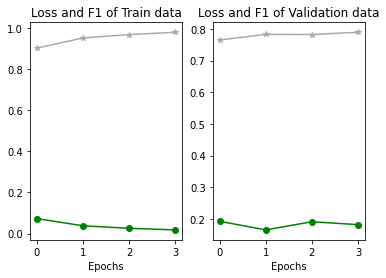

<Figure size 432x288 with 0 Axes>

In [102]:
# 'klue/roberta-base', 32, 32, lr : 2e-05, 
train_batch_size = 32
model_name = 'klue/roberta-base'

train_dataset = CustomDataset(dataset['train'])
valid_dataset = CustomDataset(dataset['validation'])

train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')
learning_rate = 2e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 4, model_name, learning_rate, weight_decay)

start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 4, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

draw_plot(train_dict, valid_dict, 0)

# hyperparameter 조정

[optuna 사용법](https://dacon.io/codeshare/2704)

- transformer의 trainer 사용
  - [trainer huggingface](https://huggingface.co/docs/transformers/main_classes/trainer)
  - [bert에 optuna 사용법-medium](https://medium.com/carbon-consulting/transformer-models-hyperparameter-optimization-with-the-optuna-299e185044a8)
  - [bert에 optuna 사용법-git블로그](https://thigm85.github.io/blog/search/cord19/bert/transformers/optuna/2020/11/07/bert-training-optuna-tuning.html)


In [17]:
import optuna

In [23]:
i = 0
def objective(trial: optuna.Trial):
    model_name = 'klue/roberta-base'
    learning_rate = trial.suggest_loguniform('learning_rate', low=5e-5, high=0.01)
    weight_decay = trial.suggest_loguniform('weight_decay', low=4e-5, high=0.01)

    train_batch_size = trial.suggest_int("per_device_train_batch_size", 16, 88)
    train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
    valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')
    
    model, optimizer, scheduler = initializer(train_dataloader, 4, model_name, learning_rate, weight_decay)
    start = time.time()
    train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 4, model_name)
    end = time.time()
    print(f"time : {(end - start)//60}분 {(end - start)%60}초")

    global i

    draw_plot(train_dict, valid_dict, i)
    i += 1

    gc.collect()
    print('\n------------------------------------------\n\n')
    return max(valid_dict['f1'])

In [24]:
train_dataset = CustomDataset(dataset['train'])
valid_dataset = CustomDataset(dataset['validation'])

In [25]:
import gc
gc.collect()

181

### klue/roberta-base

**train_batch_size, lr, epochs -> f1**

- 모두 0에 수렴
- class에 layer를 추가해야할 것 같다.

In [ ]:
print('klue/roberta-base\n\n')
# We want to minimize the loss! 
study = optuna.create_study(study_name='hyper-parameter-search', direction='maximize') 
# Optimize the objective using 5 different trials 
study.optimize(objective, n_trials=32)

# 추가학습


In [ ]:
train_batch_size = 32
model_name = 'klue/roberta-base'

train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')
learning_rate = 2e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 20, model_name, learning_rate, weight_decay)

start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 20, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

draw_plot(train_dict, valid_dict, 0)

# Test : 최적화된 모델로 KLUE-sts Validation 문장 test

csv파일로 score과 두 문장 저장

In [ ]:
model_name = ''
checkpoint = torch.load(f'/content/drive/MyDrive/Colab Notebooks/nlp/{model_name}')
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss', 'f1'])

In [ ]:
def test(model, test_dataloader):
    loss_fct = nn.MSELoss()
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc, total_f1, total_pearson= 0,0, 0, 0
    prediction = {'probs' : [], 'batch_input_ids' : []}   # batch_input_ids는 문장 확인을 위해 넣어둠.

    for step, batch in enumerate(test_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
        labels = torch.tensor([[1, 0] if label == 1 else [0, 1] for label in batch_label]).to(device)

        prediction['batch_input_ids'].extend(batch_input['input_ids'])
        
        # gradient 계산하지 않음
        with torch.no_grad():
            probs = model(**batch_input)
        pred = torch.argmin(probs, dim=1).cpu()
        
        prediction['probs'].extend(probs)

        # loss
        loss = loss_fct(probs.to(torch.float32), labels.to(torch.float32))
        total_loss += loss.item()
        
        # accuracy
        acc = 0
        for p, b in zip(pred, batch_label) :
          if p == b :
            acc += 1
        
        acc = acc / len(probs)
        total_acc+=acc
        
        # pearsonr 상관계수
        pearson = torch.corrcoef(torch.stack([probs, batch_label], dim=0))
        total_pearson += pearson

        # f1-score
        f1 = f1_score(pred, [b.cpu() for b in batch_label])
        total_f1 += f1

    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)
    total_f1 = total_f1/(step+1)
    total_pearson = total_pearson/(step+1)
    return prediction, total_loss, total_acc, total_f1, total_pearson

In [ ]:
valid_dataset = CustomDataset(dataset['validation'])
validation_loader = make_dataloader(valid_dataset, 'klue/bert-base', 32, 'valid')

model = CustomSTS(hidden_size=768, model_name='klue/bert-base')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
prediction, total_loss, total_acc, total_f1, total_pearson = test(model, validation_loader)

In [ ]:
import pandas as pd
df = pd.DataFrame({'sentence1' : [data['sentence1'] for data in dataset['validation']],
                   'sentence2' : [data['sentence2'] for data in dataset['validation']],
                   'real_label' : [data['labels']['binary-label'] for data in dataset['validation']]
                   })
df.head()

,sentence1,sentence2,real_label
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.857143
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.428571
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.285714
3,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.",3.714286
4,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,2.500000


In [ ]:
# prediction['probs'] = [p.item() for p in prediction['probs']]
df['probs'] = prediction['probs']
df['distance'] = df['real_label'] - df['probs']

In [ ]:
df['blabel'] = True
df['blabel'].loc[df['real_label'] < 3] = False

df['b_pred'] = True
df['b_pred'].loc[df['probs'] < 3] = False

In [ ]:
# 틀린 것
df.loc[df.blabel != df.b_pred]

,sentence1,sentence2,real_label,probs,distance,blabel,b_pred
6,최근 국민들의 여행심리 위축 등으로 동남아 등 다른 노선까지 영향을 받는 상황이다.,동남아시아와 같은 다른 노선은 최근 사람들의 여행 감정의 하락에 영향을 받았습니다.,3.600000,2.657490,0.942510,True,False
10,라디오 듣는 건 금지되어있어,라디오 듣는건 삼가주세요,2.500000,3.843205,-1.343205,False,True
20,덕분에 너무 즐거웠던 여행이 되었습니다!,덕분에 즐거운 일본 여행이 되었습니다.,2.833333,3.998187,-1.164853,False,True
21,와이키키 중심지로 이동이 편리한 위치에 있습니다.,와이키키 센터에 편리하게 위치해 있습니다.,2.857143,3.340758,-0.483615,False,True
25,집안에서 효율적으로 환기하고 싶을 때 뭐가 필요해?,발코니말고 집안에서 효율적으로 환기할 때 필요한 것은?,2.666667,3.322337,-0.655670,False,True
...,...,...,...,...,...,...,...
505,한메일 계정을 더 만드는건 유료니 그만 만들어,한메일 계정은 그만 만들고 네이버 계정으로 만들어,2.428571,3.097188,-0.668617,False,True
507,특히 직불금 도입 과정에서 중소규모 농가를 더 배려했습니다.,"특히, 중소 농부들은 직불금을 도입하는 과정에서 더 많은 배려를 했습니다.",2.714286,4.142483,-1.428197,False,True
508,지금 집안 습도가 얼마인지 확인할 수 있게 도와줘,집안 습도 어떤지 보고싶을 때는 뭐라고 해야하니?,3.166667,0.858109,2.308557,True,False
514,"문체부는 이를 연차적으로 확대, 시행해 학교운동부와 스포츠클럽 간의 연계를 강화한다.",문화체육관광부는 학교스포츠학과와 스포츠클럽의 연계성을 강화하기 위해 매년 이 프로그...,2.200000,3.816726,-1.616726,False,True


In [ ]:
# 예측값과 실제값이 1.5이상 차이나는 것
df[df['distance'] >= 1.5].index

Int64Index([60, 108, 149, 170, 177, 193, 234, 248, 307, 439, 446, 492, 508], dtype='int64')

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from scipy.stats import pearsonr
print(f'정확도 : {accuracy_score(df.blabel, df.b_pred):.4f}')
print(f'recall : {recall_score(df.blabel, df.b_pred):.4f}')
print(f'precision : {precision_score(df.blabel, df.b_pred):.4f}')
print(f'f1_score : {f1_score(df.blabel, df.b_pred):.4f}')
print(f"pearsonr : {pearsonr(df['real_label'], df.probs)[0]:.4f}")

정확도 : 0.8285
recall : 0.8591
precision : 0.7652
f1_score : 0.8094
pearsonr : 0.8116


In [ ]:
df.to_csv('klue-dataset-validation-prediction.csv')